##  pretrained models in PyTorch

This notebook only has the default pyTorch models

More models are available in the osmr and/or cadene repos

https://github.com/Cadene/pretrained-models.pytorch

In [1]:

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import pandas as pd

import numpy as np
import powerlaw

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams.update({'font.size': 16})

### Models in Torch

Accuracies file is taken from the Cadene website

https://github.com/Cadene/pretrained-models.pytorch

Although I discovered later that this package does not work consistantly so I just use the prebuilt pytorch models here

### <font color='red'> Check this file to ensure the numbers are correct...I am sure the trends are correct

In [3]:
accuracies = pd.read_csv('accuracies', delimiter="\t")
len(accuracies)

62

In [4]:
accuracies['platform'].unique()

array(['Tensorflow', 'ourporting', 'Caffe', 'Torch7', 'Keras', 'Pytorch'],
      dtype=object)

In [5]:
our_acc = accuracies[accuracies['platform']=='ourporting']
len(our_acc), our_acc

(24,                   model    platform    acc1    acc5
 1       PNASNet-5-Large  ourporting  82.736  95.992
 3        NASNet-A-Large  ourporting  82.566  96.086
 5              SENet154  ourporting  81.304  95.498
 7               PolyNet  ourporting  81.002  95.624
 10  SE-ResNeXt101_32x4d  ourporting  80.236  95.028
 12    InceptionResNetV2  ourporting  80.170  95.234
 13          InceptionV4  ourporting  80.062  94.926
 14    DualPathNet107_5k  ourporting  79.746  94.684
 16       DualPathNet131  ourporting  79.432  94.574
 17     DualPathNet92_5k  ourporting  79.400  94.620
 18        DualPathNet98  ourporting  79.224  94.488
 19   SE-ResNeXt50_32x4d  ourporting  79.076  94.434
 22     ResNeXt101_64x4d  ourporting  78.956  94.252
 23             Xception  ourporting  78.888  94.292
 26         SE-ResNet152  ourporting  78.658  94.374
 28         SE-ResNet101  ourporting  78.396  94.258
 30     ResNeXt101_32x4d  ourporting  78.188  93.886
 33          SE-ResNet50  ourporting  77.6

In [6]:
py_acc = accuracies[accuracies['platform']=='Pytorch']
len(py_acc), py_acc

(21,             model platform    acc1    acc5
 27      ResNet152  Pytorch  78.428  94.110
 34    DenseNet161  Pytorch  77.560  93.798
 35      ResNet101  Pytorch  77.438  93.672
 37    InceptionV3  Pytorch  77.294  93.454
 38    DenseNet201  Pytorch  77.152  93.548
 42    DenseNet169  Pytorch  76.026  92.992
 43       ResNet50  Pytorch  76.002  92.980
 45    DenseNet121  Pytorch  74.646  92.136
 46       VGG19_BN  Pytorch  74.266  92.066
 49       ResNet34  Pytorch  73.554  91.456
 51       VGG16_BN  Pytorch  73.518  91.608
 52          VGG19  Pytorch  72.080  90.822
 53          VGG16  Pytorch  71.636  90.354
 54       VGG13_BN  Pytorch  71.508  90.494
 55       VGG11_BN  Pytorch  70.452  89.818
 56       ResNet18  Pytorch  70.142  89.274
 57          VGG13  Pytorch  69.662  89.264
 58          VGG11  Pytorch  68.970  88.746
 59  SqueezeNet1_1  Pytorch  58.250  80.800
 60  SqueezeNet1_0  Pytorch  58.108  80.428
 61        Alexnet  Pytorch  56.432  79.194)

- merge dataframes
- get model names
- load pretrained
- compute lognorm
- store in data frame

In [7]:
df =  pd.concat([py_acc, our_acc])
df.head()

,model,platform,acc1,acc5
27,ResNet152,Pytorch,78.428,94.110
34,DenseNet161,Pytorch,77.560,93.798
35,ResNet101,Pytorch,77.438,93.672
37,InceptionV3,Pytorch,77.294,93.454
38,DenseNet201,Pytorch,77.152,93.548


### Minimum dimension for W

In [8]:
MIN_DIM = 50

### All Linear Models

In [9]:
def get_conv2D_Wmats(Wtensor):
    """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  Return ij (N x M) matrices"""
    Wmats = []
    s = Wtensor.shape
    N, M, imax, jmax = s[0],s[1],s[2],s[3]
    #print("tensor shape", N,M,imax,jmax)
    for i in range(imax):
        for j in range(jmax):
            W = Wtensor[:,:,i,j]
            if N < M:
                W = W.T
            Wmats.append(W)
    return Wmats

In [10]:
def count_layers(model):
    """Loops over a pytorch model and counts all the weight matrices, linear, conv2d, and conv2d-slices"""
    num_linear, num_conv2d, num_conv2d_slices = 0, 0, 0
    
    for im, m in enumerate(model.modules()):
        print(im,m)
        if isinstance(m, nn.Linear):    
            print("linear")
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                print(im,m, W.shape)
                num_linear += 1
        elif isinstance(m, nn.Conv2d):
            print("conv2d")
            Wtensor = np.array(m.weight.data.clone().cpu())
            print(Wtensor.shape)
            Wmats = get_conv2D_Wmats(Wtensor)
            print(im,m)
            num_conv2d += 1
            for W in Wmats:
                print(W.shape)
                if (np.min(W.shape) >= MIN_DIM):
                    num_conv2d_slices += 1
                
    return num_linear, num_conv2d, num_conv2d_slices
        

In [11]:
def iter_pytotch_layers(model, min_dim=MIN_DIM):
    """Iterate over a pytorch layers and  weight matrix.  
    Supports linear, conv2d, and conv2d-slices"""
    for im, m in enumerate(model.modules()):
        if isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                yield W
        elif isinstance(m, nn.Conv2d):
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            for W in Wmats:
                if (np.min(W.shape) >= min_dim):
                    yield W

In [12]:
def calc_model_lognorms(model):
    try:
        lognorms, min_svs, Qs = [], [], []

        for W in tqdm(iter_pytotch_layers(model)):
            M, N = np.min(W.shape), np.max(W.shape)
            Q = N/M
            Qs.append(Q)

            lognorm = np.log10(np.linalg.norm(W))
            lognorms.append(lognorm)

    except:
        print("skipping ", model_name)
        pass
    
    return lognorms, min_svs, Qs

In [21]:
lognorms_4model = {}
counts_4model = {}
#models = [m.lower().replace('-','') for m in df['model'].values]
model_names = []

def update_model(model_name, model):
    lognorms, min_svs, Qs = calc_model_lognorms(model)
    counts_4model[model_name] = count_layers(model)
    lognorms_4model[model_name] = [lognorms, min_svs, Qs]
    model_names.append(model_name)
    
    
try:
    model_name = 'vgg11'
    model = models.vgg11(pretrained=True)
    update_model(model_name, model)
   
    model_name = 'vgg11_bn'
    model = models.vgg11_bn(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'vgg13'
    model = models.vgg13(pretrained=True)
    update_model(model_name, model)
   
    model_name = 'vgg13_bn'
    model = models.vgg13_bn(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'vgg16'
    model = models.vgg16(pretrained=True)
    update_model(model_name, model)
   
    model_name = 'vgg16_bn'
    model = models.vgg16_bn(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'vgg19'
    model = models.vgg19(pretrained=True)
    update_model(model_name, model)
   
    model_name = 'vgg19_bn'
    model = models.vgg19_bn(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'squeezenet1_0'
    model = models.squeezenet1_0(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'squeezenet1_1'
    model = models.squeezenet1_1(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet121'
    model = models.densenet121(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet161'
    model = models.densenet161(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet169'
    model = models.densenet169(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'densenet201'
    model = models.densenet201(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'resnet18'
    model = models.resnet18(pretrained=True)
    update_model(model_name, model)
    
    model_name = 'resnet34'
    model = models.resnet34(pretrained=True)
    update_model(model_name, model)
        
    model_name = 'resnet50'
    model = models.resnet50(pretrained=True)
    update_model(model_name, model)

    model_name = 'resnet101'
    model = models.resnet101(pretrained=True)
    update_model(model_name, model)

    model_name = 'resnet152'
    model = models.resnet152(pretrained=True)
    update_model(model_name, model)


except:
    pass


0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, k


0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stri


0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Con


0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

38 Linear(in_features=25088, out_features=4096, bias=True) (4096, 25088)
39 ReLU(inplace)
40 Dropout(p=0.5)
41 Linear(in_features=4096, out_features=4096, bias=True)
linear
41 Linear(in_features=4096, out_features=4096, bias=True) (4096, 4096)
42 ReLU(inplace)
43 Dropout(p=0.5)
44 Linear(in_features=4096, out_features=1000, bias=True)
linear
44 Linear(in_features=4096, out_features=1000, bias=True) (1000, 4096)



0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Con


0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

47 Linear(in_features=25088, out_features=4096, bias=True) (4096, 25088)
48 ReLU(inplace)
49 Dropout(p=0.5)
50 Linear(in_features=4096, out_features=4096, bias=True)
linear
50 Linear(in_features=4096, out_features=4096, bias=True) (4096, 4096)
51 ReLU(inplace)
52 Dropout(p=0.5)
53 Linear(in_features=4096, out_features=1000, bias=True)
linear
53 Linear(in_features=4096, out_features=1000, bias=True) (1000, 4096)



0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inpla

40 Linear(in_features=25088, out_features=4096, bias=True) (4096, 25088)
41 ReLU(inplace)
42 Dropout(p=0.5)
43 Linear(in_features=4096, out_features=4096, bias=True)
linear
43 Linear(in_features=4096, out_features=4096, bias=True) (4096, 4096)
44 ReLU(inplace)
45 Dropout(p=0.5)
46 Linear(in_features=4096, out_features=1000, bias=True)
linear
46 Linear(in_features=4096, out_features=1000, bias=True) (1000, 4096)



0 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

56 Linear(in_features=25088, out_features=4096, bias=True) (4096, 25088)
57 ReLU(inplace)
58 Dropout(p=0.5)
59 Linear(in_features=4096, out_features=4096, bias=True)
linear
59 Linear(in_features=4096, out_features=4096, bias=True) (4096, 4096)
60 ReLU(inplace)
61 Dropout(p=0.5)
62 Linear(in_features=4096, out_features=1000, bias=True)
linear
62 Linear(in_features=4096, out_features=1000, bias=True) (1000, 4096)


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)



0 SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, ke


0 SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, paddin

(192, 48, 3, 3)
40 Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
41 ReLU(inplace)
42 Fire(
  (squeeze): Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
  (squeeze_activation): ReLU(inplace)
  (expand1x1): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
  (expand1x1_activation): ReLU(inplace)
  (expand3x3): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (expand3x3_activation): ReLU(inplace)
)
43 Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
conv2d
(48, 384, 1, 1)
43 Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
(384, 48)
44 ReLU(inplace)
45 Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
conv2d
(192, 48, 1, 1)
45 Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
(192, 48)
46 ReLU(inplace)
47 Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
conv2d
(192, 48, 3, 3)
47 Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), pad

/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)



0 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp


0 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(in

446 BatchNorm2d(1344, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
447 ReLU(inplace)
448 Conv2d(1344, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
conv2d
(192, 1344, 1, 1)
448 Conv2d(1344, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
(1344, 192)
449 BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
450 ReLU(inplace)
451 Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
conv2d
(48, 192, 3, 3)
451 Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
(192, 48)
452 _DenseLayer(
  (norm1): BatchNorm2d(1392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1392, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): 


0 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

(128, 992, 1, 1)
455 Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
(992, 128)
456 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
457 ReLU(inplace)
458 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
conv2d
(32, 128, 3, 3)
458 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
459 _DenseLayer(
  (norm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
460 BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
461 ReLU(inplace


0 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

(128, 32)
(128, 32)
467 _DenseLayer(
  (norm1): BatchNorm2d(1728, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv1): Conv2d(1728, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
468 BatchNorm2d(1728, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
469 ReLU(inplace)
470 Conv2d(1728, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
conv2d
(128, 1728, 1, 1)
470 Conv2d(1728, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
(1728, 128)
471 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
472 ReLU(inplace)
473 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
conv2d
(32, 128, 3, 3)
473 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b


0 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2):


0 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2):


0 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia


0 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia


0 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia

416 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
conv2d
(512, 512, 3, 3)
416 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
417 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
418 Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
conv2d
(2048, 512, 1, 1)
418 Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
(2048, 512)
419 BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
420 ReLU(inplace)
421 AvgPool2d(kernel_size=7, stride=1, padding=0)
422 Linear(in_features=2048, out_features=1000, bias=True)
linear
422 Linear(in_features=2048, out_features=1000, bias=True) (1000, 2048)


In [25]:
df.head()

,model,platform,acc1,acc5,modelname
27,ResNet152,Pytorch,78.428,94.110,resnet152
34,DenseNet161,Pytorch,77.560,93.798,densenet161
35,ResNet101,Pytorch,77.438,93.672,resnet101
37,InceptionV3,Pytorch,77.294,93.454,inceptionv3
38,DenseNet201,Pytorch,77.152,93.548,densenet201


In [26]:
df['modelname'] = df['model'].apply(lambda x: x.lower().replace('-',''))
df

,model,platform,acc1,acc5,modelname
27,ResNet152,Pytorch,78.428,94.110,resnet152
34,DenseNet161,Pytorch,77.560,93.798,densenet161
35,ResNet101,Pytorch,77.438,93.672,resnet101
37,InceptionV3,Pytorch,77.294,93.454,inceptionv3
38,DenseNet201,Pytorch,77.152,93.548,densenet201
42,DenseNet169,Pytorch,76.026,92.992,densenet169
43,ResNet50,Pytorch,76.002,92.980,resnet50
45,DenseNet121,Pytorch,74.646,92.136,densenet121
46,VGG19_BN,Pytorch,74.266,92.066,vgg19_bn
49,ResNet34,Pytorch,73.554,91.456,resnet34


In [27]:
df['modelname']

27             resnet152
34           densenet161
35             resnet101
37           inceptionv3
38           densenet201
42           densenet169
43              resnet50
45           densenet121
46              vgg19_bn
49              resnet34
51              vgg16_bn
52                 vgg19
53                 vgg16
54              vgg13_bn
55              vgg11_bn
56              resnet18
57                 vgg13
58                 vgg11
59         squeezenet1_1
60         squeezenet1_0
61               alexnet
1          pnasnet5large
3           nasnetalarge
5               senet154
7                polynet
10    seresnext101_32x4d
12     inceptionresnetv2
13           inceptionv4
14     dualpathnet107_5k
16        dualpathnet131
17      dualpathnet92_5k
18         dualpathnet98
19     seresnext50_32x4d
22      resnext101_64x4d
23              xception
26           seresnet152
28           seresnet101
30      resnext101_32x4d
33            seresnet50
36           fbresnet152


In [28]:
avg_lognorms = {}
avg_lognorms_m1 = {}
len_lognorms = {}

for model_name in df['modelname'].values:
    avg_lognorms[model_name] = 0.0
    len_lognorms[model_name] = 0.0
    avg_lognorms_m1[model_name] = 0.0
    
    if(model_name in lognorms_4model):
        avg_lognorms[model_name] = np.average(lognorms_4model[model_name][0])
        avg_lognorms_m1[model_name] = np.average(lognorms_4model[model_name][0][:-1])

        len_lognorms[model_name] = len(lognorms_4model[model_name][0])

In [29]:
df['avg_lognorm'] = df['modelname'].apply(lambda x: avg_lognorms[x] )
df['avg_lognorm_m1'] = df['modelname'].apply(lambda x: avg_lognorms_m1[x] )

df['num_layers'] = df['modelname'].apply(lambda x: int(len_lognorms[x]) )

In [30]:
df.sort_values('model')

,model,platform,acc1,acc5,modelname,avg_lognorm,avg_lognorm_m1,num_layers
61,Alexnet,Pytorch,56.432,79.194,alexnet,0.000000,0.000000,0
50,BNInception,ourporting,73.522,91.560,bninception,0.000000,0.000000,0
41,CaffeResnet101,ourporting,76.200,92.766,cafferesnet101,0.000000,0.000000,0
45,DenseNet121,Pytorch,74.646,92.136,densenet121,0.806511,0.791909,62
34,DenseNet161,Pytorch,77.560,93.798,densenet161,0.751560,0.739612,82
42,DenseNet169,Pytorch,76.026,92.992,densenet169,0.741184,0.729807,86
38,DenseNet201,Pytorch,77.152,93.548,densenet201,0.718848,0.709136,102
14,DualPathNet107_5k,ourporting,79.746,94.684,dualpathnet107_5k,0.000000,0.000000,0
16,DualPathNet131,ourporting,79.432,94.574,dualpathnet131,0.000000,0.000000,0
44,DualPathNet68,ourporting,75.868,92.774,dualpathnet68,0.000000,0.000000,0


In [31]:
df_vgg11 = df[(df['model']=='VGG11')| (df['model']=='VGG11_BN')]
df_vgg11['legend']='VGG11'

df_vgg13 = df[(df['model']=='VGG13')| (df['model']=='VGG13_BN')]
df_vgg13['legend']='VGG13'

df_vgg16 = df[(df['model']=='VGG16')| (df['model']=='VGG16_BN')]
df_vgg16['legend']='VGG16'

df_vgg19 = df[(df['model']=='VGG19')| (df['model']=='VGG19_BN')]
df_vgg19['legend']='VGG19'

df_squeezenet = df[(df['model']=='SqueezeNet1_0')| (df['model']=='SqueezeNet1_1')]
df_squeezenet['legend']='SqueezeNet'

df_resnxt = df[(df['model']=='ResNeXt101_32x4d')| (df['model']=='ResNeXt101_64x4d')]
df_resnxt['legend']='ResNeXT101'


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

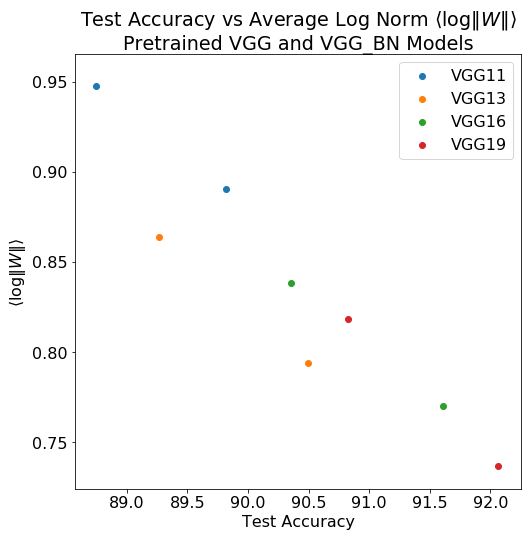

In [34]:
plt.rcParams['figure.figsize'] = [8,8]


for mf in [df_vgg11, df_vgg13, df_vgg16, df_vgg19]:
#for mf in [df_vgg11, df_vgg13]:
    x = mf['acc5'].values
    y = mf['avg_lognorm'].values
    label = mf['legend'].values[0]
    plt.scatter(x,y,label=label)

plt.legend()
plt.title(r"Test Accuracy vs Average Log Norm $\langle\log\Vert W\Vert\rangle$"+"\nPretrained VGG and VGG_BN Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\langle\log\Vert W\Vert\rangle$")
plt.savefig("img/vgg-lognorms.png")

### ResNet

Only exception is InceptionResNetv2

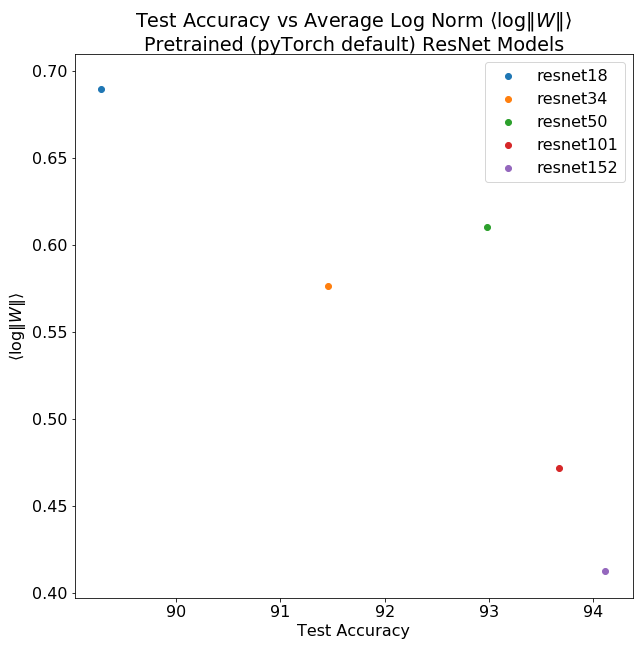

In [49]:
plt.rcParams['figure.figsize'] = [10,10]

x, y = [], []

modelnames = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']

for name in modelnames:
    if 'resnet' in name:
        mf = df[df.modelname==name]
        x = mf['acc5'].values
        y = mf['avg_lognorm'].values
        if y > 0:
            plt.scatter(x,y, label=name)
        
plt.title(r"Test Accuracy vs Average Log Norm $\langle\log\Vert W\Vert\rangle$"+"\nPretrained (pyTorch default) ResNet Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\langle\log\Vert W\Vert\rangle$")
plt.legend()
plt.savefig("img/resnet-pytorch.png")

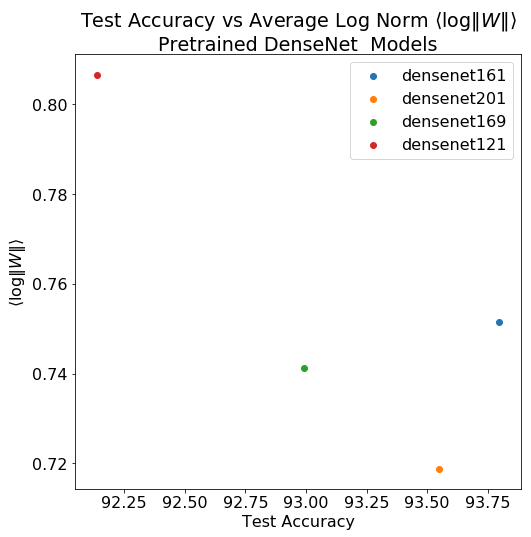

In [50]:
plt.rcParams['figure.figsize'] = [8,8]

x, y = [], []

for name in df.modelname: 
    if 'densenet' in name and 'resnet' not in name:
        #print(name)
        mf = df[df.modelname==name]
        x = mf['acc5'].values
        y = mf['avg_lognorm'].values
        if y > 0:
            plt.scatter(x,y, label=name)
        
plt.title(r"Test Accuracy vs Average Log Norm $\langle\log\Vert W\Vert\rangle$"+"\nPretrained DenseNet  Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\langle\log\Vert W\Vert\rangle$")
plt.legend()
plt.savefig("img/densenet.png")

### ResNeXt, SqueezeNet

squeezenet1_0
squeezenet1_1


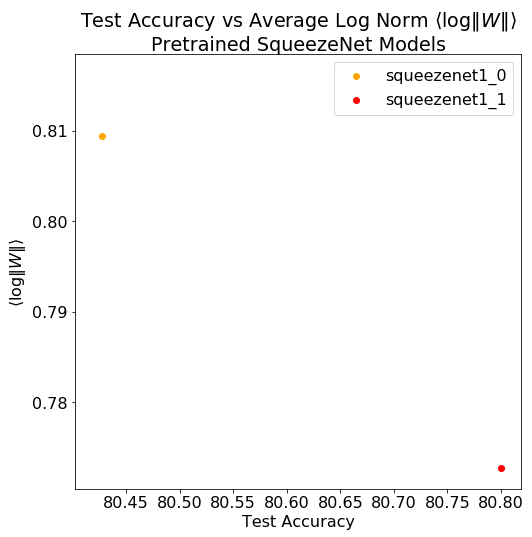

In [54]:
for mf in [df_squeezenet]:
    for ix in [1,0]:
        x = mf['acc5'].values[ix]
        y = mf['avg_lognorm'].values[ix]
        label = mf.modelname.values[ix] # mf['legend'].values[ix]
        print(label)
        color =  'red' if ix==0  else 'orange' 
        plt.scatter(x,y,label=label, color=color)
        
plt.legend()
plt.title(r"Test Accuracy vs Average Log Norm $\langle\log\Vert W\Vert\rangle$"+"\nPretrained SqueezeNet Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\langle\log\Vert W\Vert\rangle$")
plt.savefig("img/squeezenext.png")

resnext101_32x4d
resnext101_64x4d


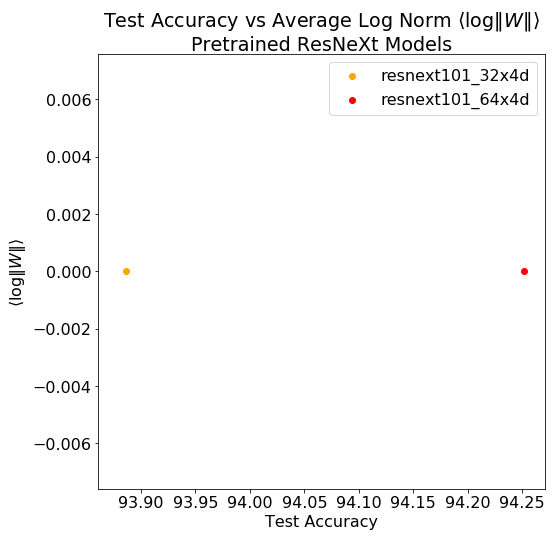

In [55]:
for mf in [df_resnxt]:
    for ix in [1,0]:
        x = mf['acc5'].values[ix]
        y = mf['avg_lognorm'].values[ix]
        label = mf.modelname.values[ix] # mf['legend'].values[ix]
        print(label)
        color =  'red' if ix==0  else 'orange' 
        plt.scatter(x,y,label=label, color=color)
        
plt.legend()
plt.title(r"Test Accuracy vs Average Log Norm $\langle\log\Vert W\Vert\rangle$"+"\nPretrained ResNeXt Models")
plt.xlabel(r"Test Accuracy")
plt.ylabel(r"$\langle\log\Vert W\Vert\rangle$")
plt.savefig("img/resnext.png")

### Norms as a function of Layer

23 0.8093861 0.7727561 0.036629975
top 100
0.036629975


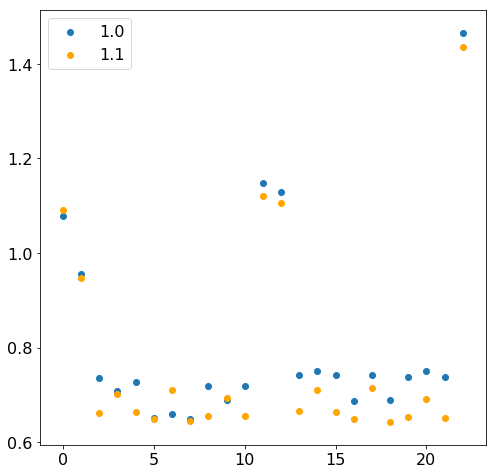

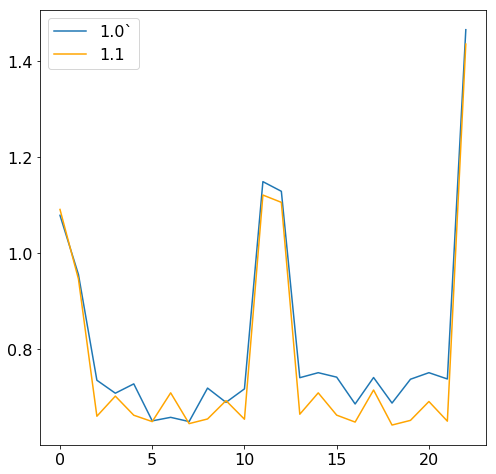

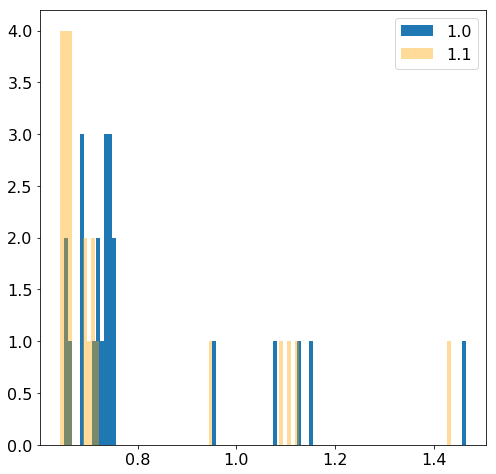

In [52]:
a = lognorms_4model['squeezenet1_0'][0]
b = lognorms_4model['squeezenet1_1'][0]

print(len(a),np.average(a) , np.average(b), np.average(a) - np.average(b))

print('top 100')
print(np.average(a[:100]) -  np.average(b[:100]))

plt.scatter(np.arange(len(a)), a,label='1.0');
plt.scatter(np.arange(len(b)), b,label='1.1', color='orange');
plt.legend()
plt.show()

plt.plot(np.arange(len(a)), a,label='1.0`');
plt.plot(np.arange(len(b)), b,label='1.1', color='orange');
plt.legend()
plt.show()

plt.hist(a,bins=100, label='1.0');
plt.hist(b,bins=100,  label='1.1', color='orange', alpha=0.4);
plt.legend()
plt.show()


62 0.8065107 0.7188484 0.08766228
top 100
0.0979746


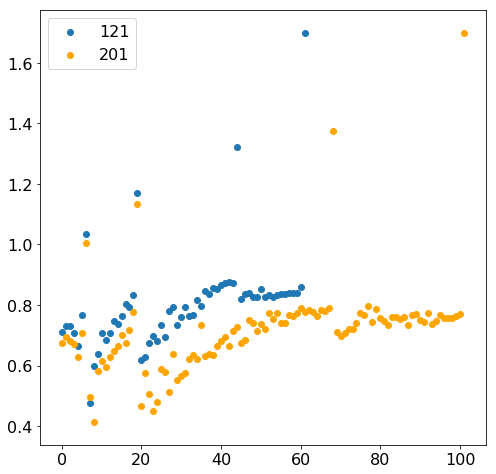

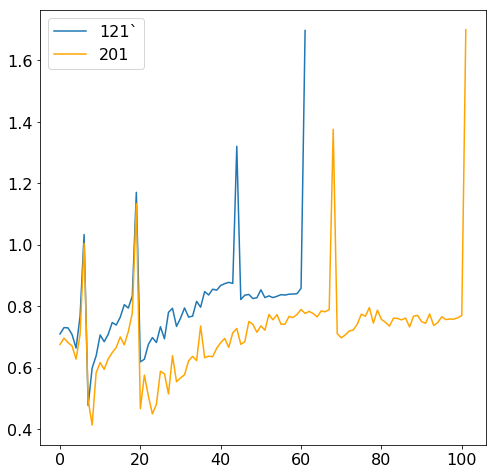

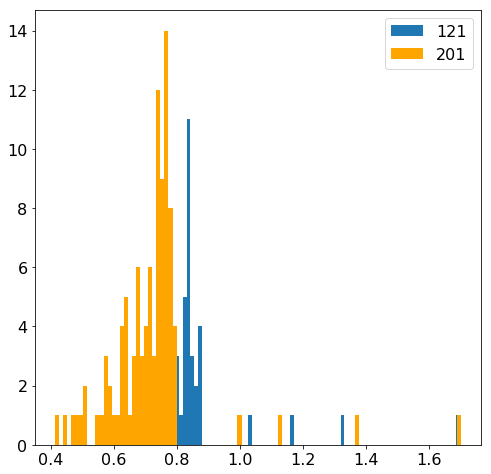

In [53]:
a = lognorms_4model['densenet121'][0]
b = lognorms_4model['densenet201'][0]

print(len(a),np.average(a) , np.average(b), np.average(a) - np.average(b))

print('top 100')
print(np.average(a[:100]) -  np.average(b[:100]))

plt.scatter(np.arange(len(a)), a,label='121');
plt.scatter(np.arange(len(b)), b,label='201', color='orange');
plt.legend()
plt.show()

plt.plot(np.arange(len(a)), a,label='121`');
plt.plot(np.arange(len(b)), b,label='201', color='orange');
plt.legend()
plt.show()

plt.hist(a,bins=100, label='121');
plt.hist(b,bins=100,  label='201', color='orange');
plt.legend()
plt.show()
